(None, 256, 256, 1)
(None, 256, 256, 1)
(None, 256, 256, 1)
(None, 256, 256, 1)
(None, 256, 256, 1) (None, 256, 256, 2)
dice (None, 256, 256, 2) (None, 256, 256, 2)
Loaded weights from the checkpoint and continued training.
256 256
1/1 [==============================] - 1s 590ms/step


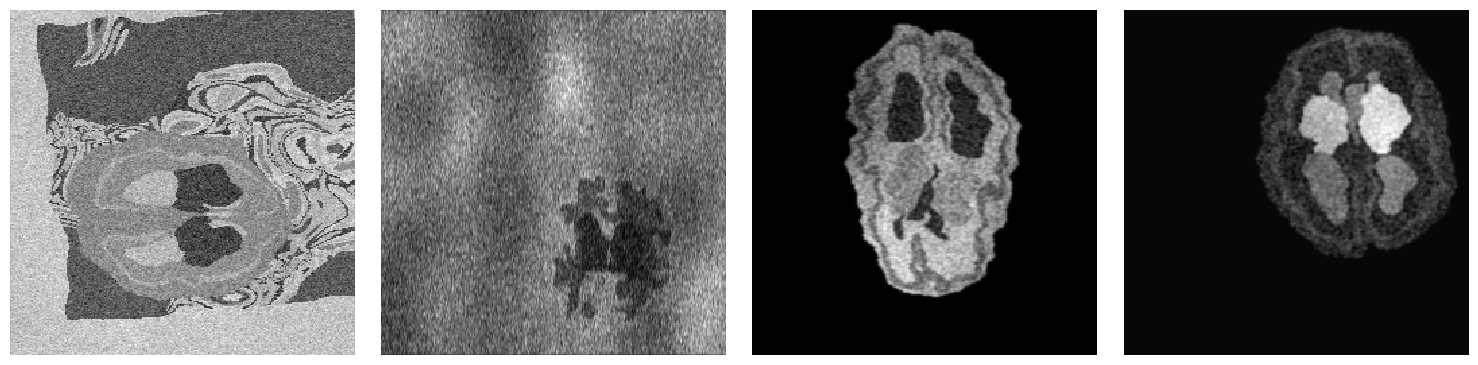

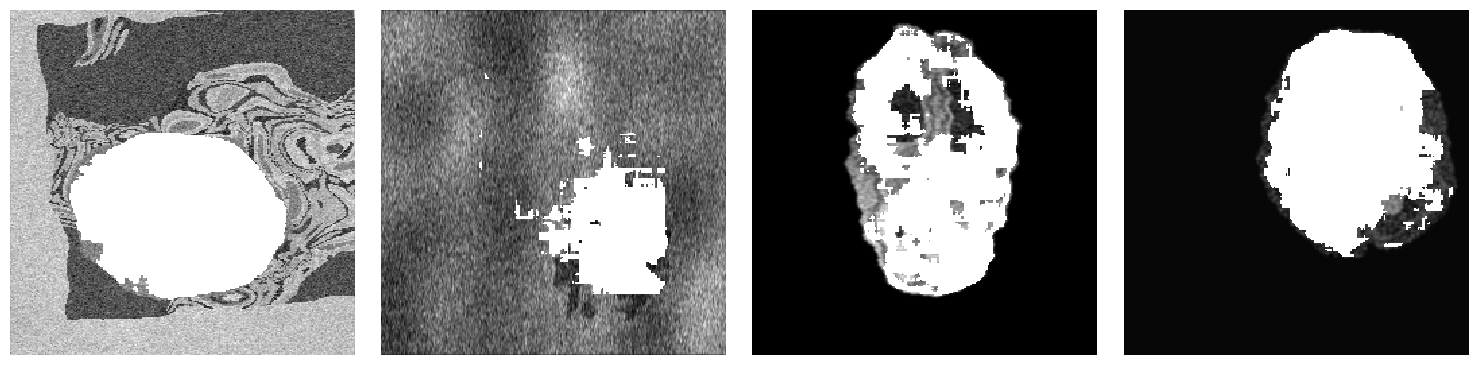

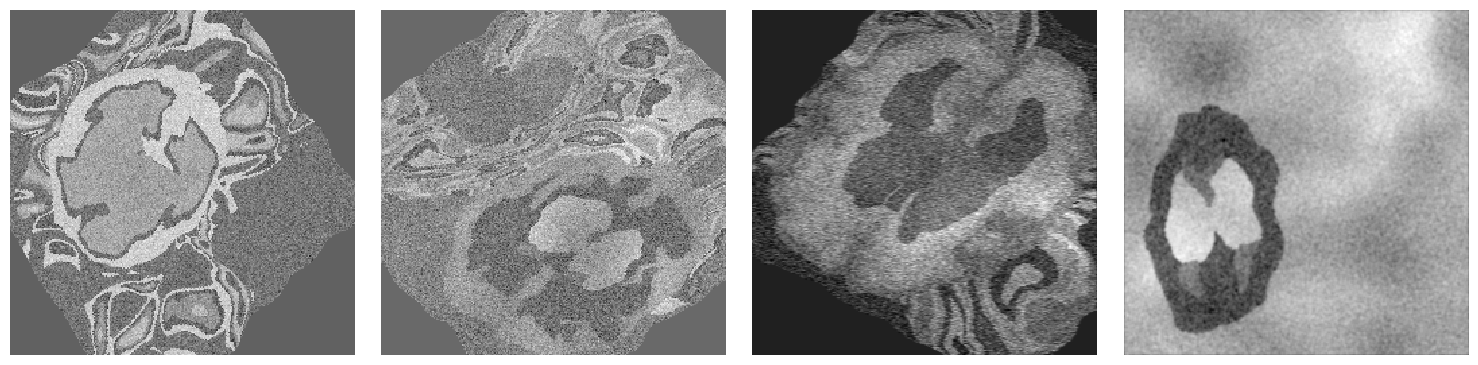

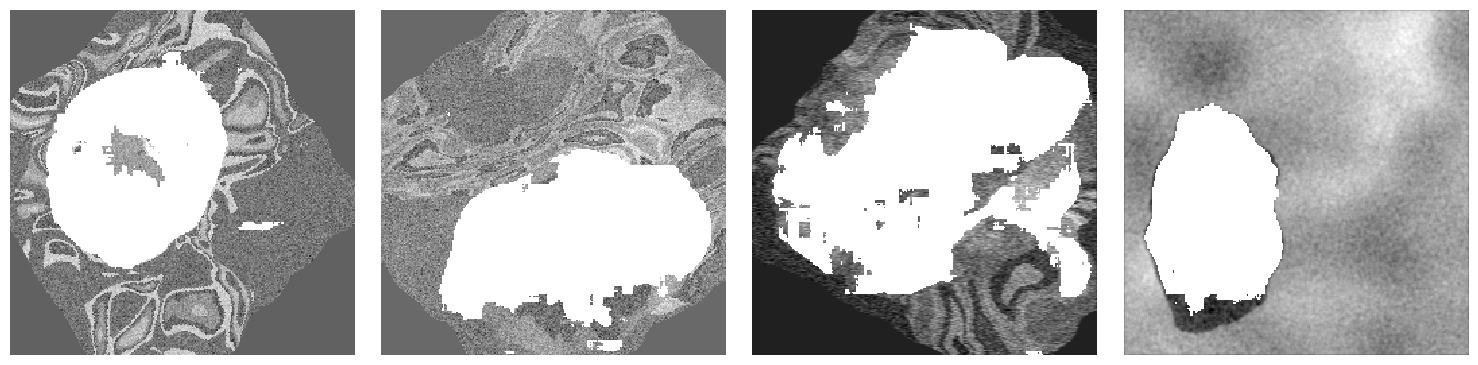

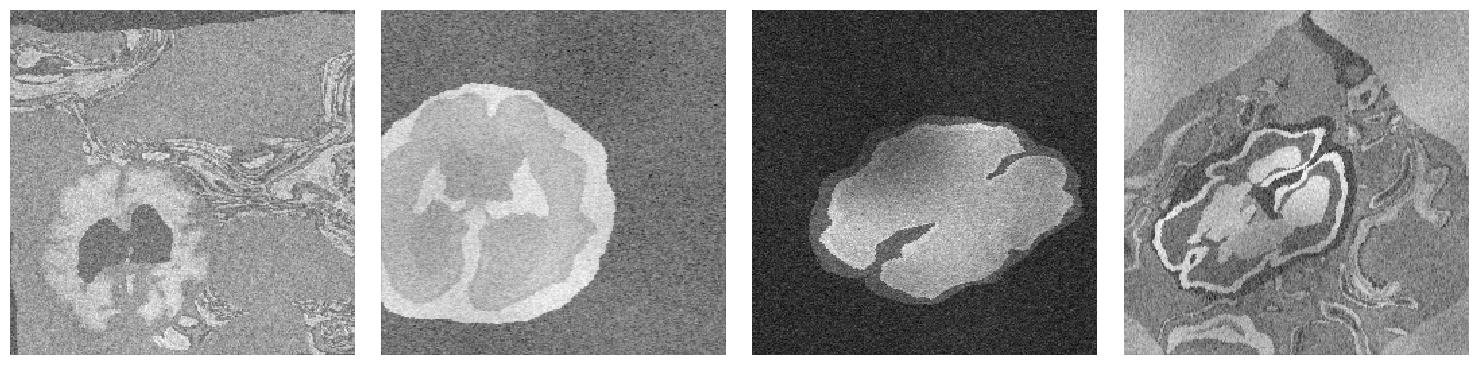

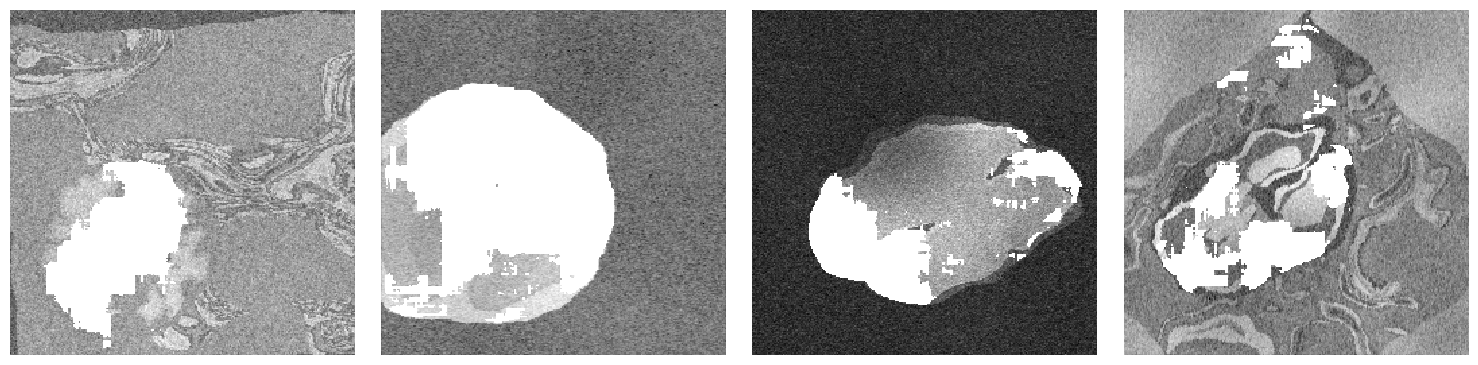

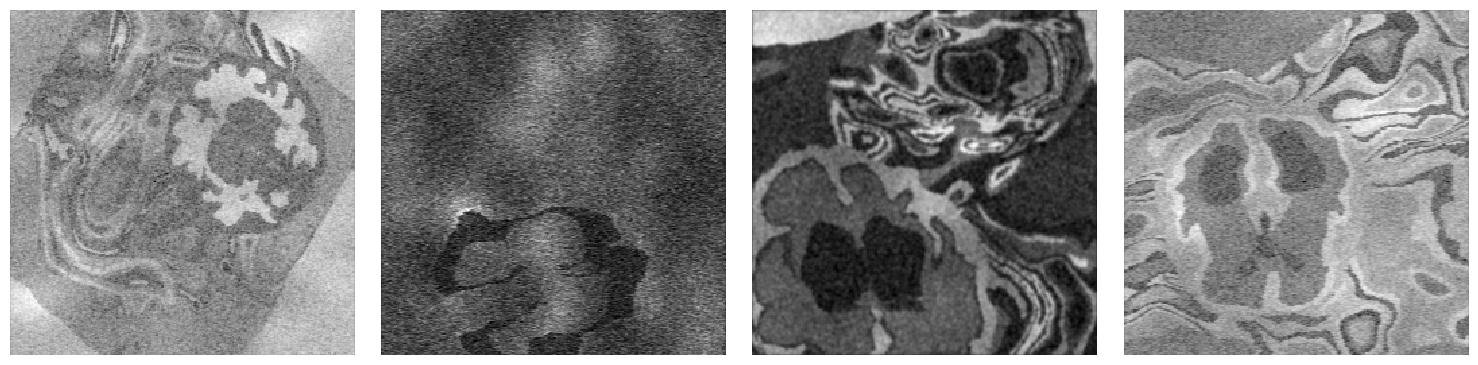

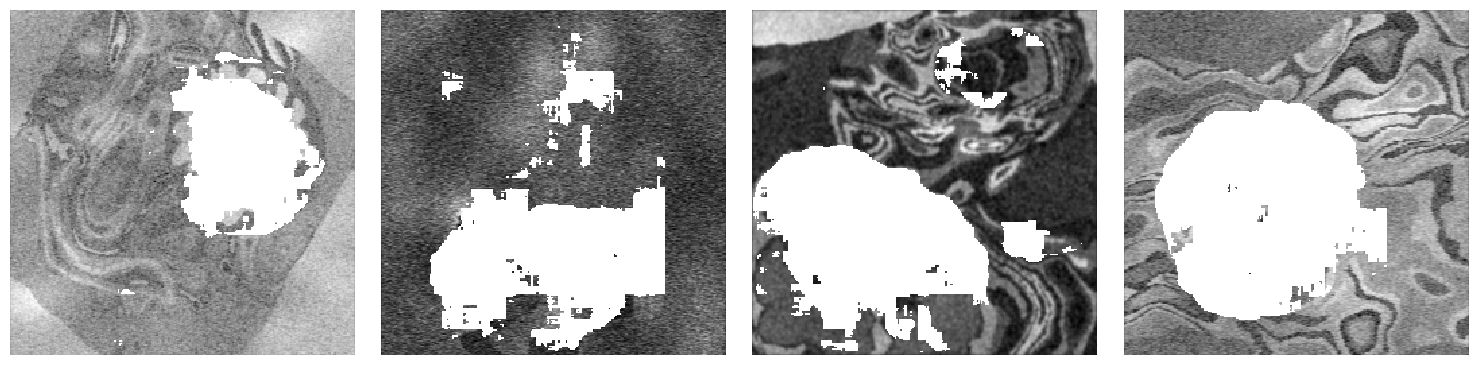

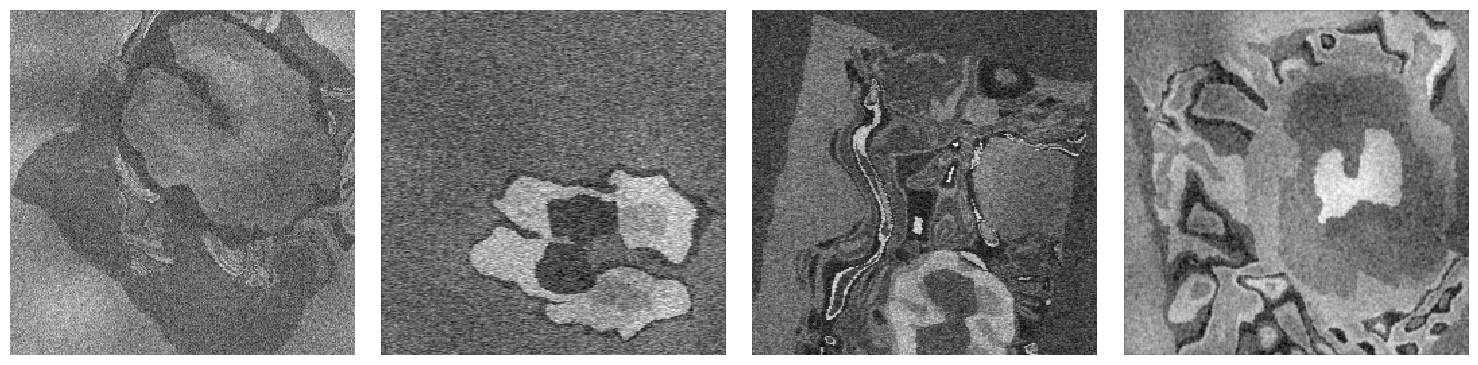

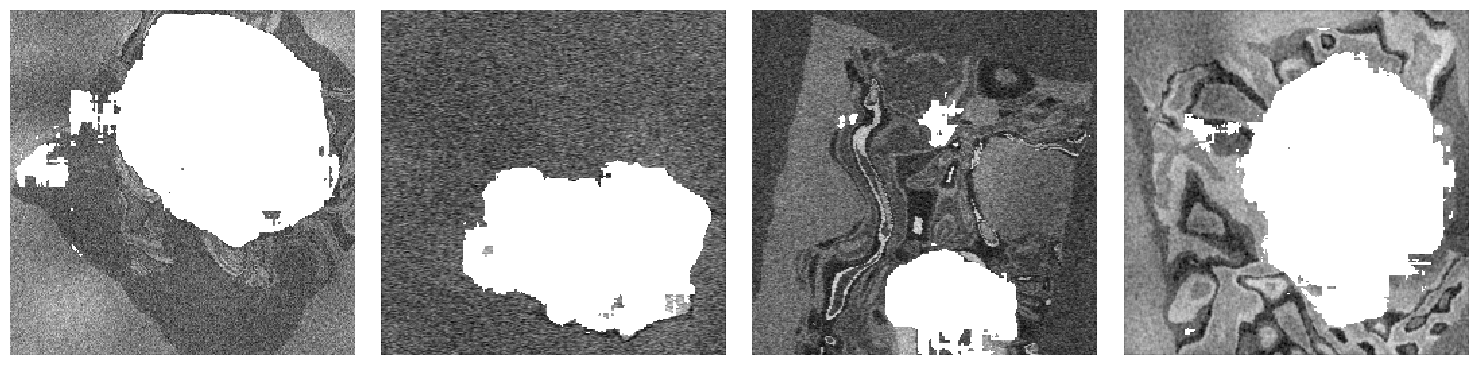

In [33]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
import numpy as np
import os
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full

import tensorflow.keras.layers as KL
import voxelmorph as vxm
from utils import *
import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau

# parser = argparse.ArgumentParser(description='Process some integers.')
# # parser.add_argument('-s','--source',type=str,help="source atlas")
# # parser.add_argument('-t','--target',type=str,help="target atlas")
# # parser.add_argument('-task','--task',type=str,default="rest1",help="task")
# parser.add_argument('-lr','--learning_rate',type=float, default=0.0001, help="learning rate")
# parser.add_argument('-nc','--nb_conv_per_level',type=int, default=2, help="learning rate")
# parser.add_argument('-ie','--initial_epoch',type=int,default=0,help="initial epoch")
# parser.add_argument('-b','--batch_size',type=int,help="initial epoch")
# parser.add_argument('-e', '--encoder_layers', nargs='+', type=int, help="A list of dimensions for the encoder")
# parser.add_argument('-d', '--decoder_layers', nargs='+', type=int, help="A list of dimensions for the decoder")

# args = parser.parse_args()

# nb_features=64
# if args.encoder_layers:
# nb_features = '_'.join(map(str, args.encoder_layers))

# log_dir='logs_feta_mom_brain_params_'+str(nb_features)
# models_dir='models_feta_mom_brain_params_'+str(nb_features)
data_dir = 'feta_2d/'
# initial_epoch=args.initial_epoch
# checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'

# if not os.path.exists(log_dir):
#     os.makedirs(log_dir)

# if not os.path.exists(models_dir):
#     os.makedirs(models_dir)
    
nb_labels=8
dimx=256
dimy=256



batch_size=1
warp_max=2   
warp_max=2.5
warp_min=.5
warp_blur_min=np.array([2, 4, 8])
warp_blur_max=warp_blur_min*2
bias_blur_min=np.array([2, 4, 8])
bias_blur_max=bias_blur_min*2
initial_lr=1e-4
nb_conv_per_level=2
# lr = args.learning_rate
nb_levels=5
conv_size=3
num_epochs=50000
num_bg_labels=16
warp_fwhm_min=10
warp_fwhm_max=20
warp_min_shapes=10
warp_max_shapes=50
in_shape=(dimx,dimy)
bg_brain = True
labels_in=[i for i in range(num_bg_labels+nb_labels)]
labels_in_unique = np.unique(labels_in).astype(int)
image_fwhm_min=20
image_fwhm_max=30
aff_shift=32
aff_scale=0.2
aff_shear=0.1
bias_min=0.01
bias_max=0.2
zero_background=0.3

kwargs_shapes = {
'num_label': num_bg_labels,
'nb_labels':nb_labels,
'warp_min': warp_min_shapes,
'warp_max': warp_max_shapes,
'image_fwhm_max':image_fwhm_max,
'image_fwhm_min':image_fwhm_min,
'zero_background':zero_background
}

gen_arg = {
    'in_shape': in_shape,
    'labels_in': labels_in,
    'labels_out': {i: 1 if i > 0 and i < nb_labels else 0 for i in range(num_bg_labels+nb_labels)},  
    'warp_min': warp_min,
    'one_hot':True,
    'axes_flip':True,
    'axes_swap':True,
    'warp_max': warp_max,
    'aff_shift':aff_shift,
    'aff_rotate':180,
    'aff_scale':aff_scale,
    'aff_shear':aff_shear,
    'bias_min':bias_min,
    'bias_max':bias_max,
    'bias_func':tf.exp,
    'zero_background':zero_background
}

    
def load_data(data_dir):
    
    subject_dirs = [d for d in os.listdir(data_dir) if d.startswith('sub-')]
    seg_image_filenames = []
    real_image_filenames = []
    fetal_data = []  # List to store fetal images
    fetal_segmentation_masks = []  # List to store fetal segmentation masks
    
    for subject_dir in subject_dirs:
        subject_prefix = subject_dir
    
        # Search for the T2-weighted image and segmented brain image with flexible naming patterns
        t2w_path = None
        dseg_path = None
        # print(os.path.join(data_dir, subject_prefix))
        for filename in os.listdir(os.path.join(data_dir, subject_prefix)):
            if "_T2w.nii.gz" in filename:
                t2w_path = os.path.join(data_dir, subject_prefix, filename)
            elif "_dseg.nii.gz" in filename:
                dseg_path = os.path.join(data_dir, subject_prefix, filename)
    
        if t2w_path is None or dseg_path is None:
            print(f"Data not found for subject {subject_prefix}. Skipping...")
            continue
    
        # Append the filenames to the respective lists
        real_image_filenames.append(t2w_path)
        seg_image_filenames.append(dseg_path)
        
    for i in range(len(real_image_filenames)):
        # Load the 2D image
        img_path = real_image_filenames[i]
        real_img = nib.load(img_path).get_fdata()

        seg_img_path = seg_image_filenames[i]
        seg_img = nib.load(seg_img_path).get_fdata()

        min_value = np.min(real_img)
        max_value = np.max(real_img)
        real_img = (real_img - min_value) / (max_value - min_value)

        real_img = tf.expand_dims(real_img, axis=0)  # Shape becomes (1, 160, 192, 1)
        fetal_data.append(real_img)
        fetal_segmentation_masks.append(seg_img)
    return fetal_data, fetal_segmentation_masks

fetal_data, fetal_segmentation_masks = load_data(data_dir)
X_train, X_test, y_train, y_test = train_test_split(fetal_data, fetal_segmentation_masks, test_size=0.2, random_state=42)





############################# TRAINING #############################################################
en=[16,32,64,64,64,64,64]
de=[64,64,64,64,64,32,16,2]
num_shapes = 20
num_rows = 10
num_cols = 4

# if args.:
nb_features = '_'.join(map(str, en))
    

log_dir='logs_feta'
models_dir='models_feta_mom_brain_params_'+str(nb_features)
initial_epoch=1000
checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'

random.seed(3000)
input_img = Input(shape=(dimx, dimy,1))
labels_to_image_model = ne.models.labels_to_image_new(**gen_arg)#,input_model=labels_to_labels_model)


unet_model = vxm.networks.Unet(inshape=(dimx, dimy, 1), nb_features=[en, de], 
                               nb_conv_per_level=nb_conv_per_level,
                               final_activation_function=tf.nn.softmax)

labels_to_image_model = ne.models.labels_to_image_new(**gen_arg)

input_img = Input(shape=(dimx, dimy))
generated_img, y = labels_to_image_model(input_img)
print(generated_img.shape,y.shape)

segmentation = unet_model(generated_img)
combined_model = Model(inputs=input_img, outputs=segmentation)
combined_model.add_loss(dice_loss(y, segmentation))

combined_model.compile(optimizer=Adam(learning_rate=initial_lr))
# data_generator = my_generator(y_train, batch_size=batch_size, same_subj=False, flip=False,**kwargs_shapes)
if os.path.exists(checkpoint_path):
    combined_model.load_weights(checkpoint_path)
    print("Loaded weights from the checkpoint and continued training.")
else:
    print("Checkpoint file not found.")
    
combined_images=[]
y_preds=[]
y_masks=[]
# combined_segmentations=[]
data_generator = my_generator(y_test, batch_size=1, same_subj=False, flip=False,**kwargs_shapes)
num_iterations = 10  # Set the number of iterations as needed

for i in range(num_shapes):
    gg, y = next(data_generator)
    generated_img, y = labels_to_image_model(gg)
    
    y_pred = unet_model.predict(generated_img, verbose=0)
    y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
    y= tf.argmax(y, axis=-1, output_type=tf.int32)
    # print(y.shape)
    y_preds.append(y_pred)
    y_masks.append(y)
    combined_images.append(generated_img)
    
image_rows = [combined_images[i:i+num_cols] for i in range(0, len(combined_images), num_cols)]
preds_masks = [y_masks[i:i+num_cols] for i in range(0, len(y_masks), num_cols)]
preds_rows = [y_preds[i:i+num_cols] for i in range(0, len(y_preds), num_cols)]

for i in range(len(image_rows)):
    im_row = image_rows[i]
    pred_row = preds_rows[i]
    mask_row = preds_masks[i]

    overlay_images = []
    for i in range(len(im_row)):
        im = im_row[i]
        mask = pred_row[i]
        im = im.numpy()  # Convert TensorFlow tensor to NumPy array
        mask = mask.numpy() 
    
        # Convert the mask to a 3-channel mask if needed (assuming a binary mask)
        # mask_rgb = np.stack((mask, mask, mask), axis=-1)
    
        # Overlay the mask on the image with the specified alpha
        overlay = im.copy()
        overlay[mask > 0] = 1
        overlay_images.append(overlay)

    # overlay_images.append(overlay)
    ne.plot.slices([list(shape) for shape in im_row], cmaps=['gray'] * num_cols)
    # ne.plot.slices([list(mask) for mask in mask_row], cmaps=['gray'] * num_cols)
    ne.plot.slices([list(pred) for pred in overlay_images], cmaps=['gray'] * num_cols)
